In [2]:
import pandas as pd
import os
import numpy as np
import pandas_profiling

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

# Required to display image inline
from IPython.display import Image

# Advanced plotting functionality with seaborn
import seaborn as sns
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

import folium  #needed for interactive map
from folium.plugins import HeatMap

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [3]:
path = 'DataSet/Original'
file = 'yellow_trips_new.csv'

yellow_trips = pd.read_csv(path + '/' + file, sep = ',', doublequote = True)

In [4]:
yellow_trips.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,total_amount
0,2014-04-03 18:28:10,2014-04-03 18:54:32,-74.006033,40.706284,-73.918837,40.744946,1,8.70,34.8
1,2014-04-16 15:42:00,2014-04-16 16:07:00,-73.979558,40.749357,0.000000,0.000000,1,9.37,30.0
2,2014-04-13 18:04:00,2014-04-13 18:07:00,-73.956453,40.775307,-73.954792,40.784992,1,0.89,6.5
3,2014-05-21 19:33:00,2014-05-21 19:45:00,-73.987212,40.757850,-73.960198,40.775472,1,2.40,12.5
4,2014-05-30 16:28:00,2014-05-30 16:51:00,-73.974292,40.755397,-74.011867,40.704222,3,5.58,24.5


In [5]:
yellow_trips['pickup_datetime'] = pd.to_datetime(yellow_trips['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
yellow_trips['dropoff_datetime'] = pd.to_datetime(yellow_trips['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
yellow_trips['pickup_month'] = yellow_trips['pickup_datetime'].dt.year*100 + yellow_trips['pickup_datetime'].dt.month
yellow_trips['dropoff_month'] = yellow_trips['dropoff_datetime'].dt.year*100 + yellow_trips['dropoff_datetime'].dt.month

In [6]:
print(yellow_trips.shape)
yellow_trips_2 = yellow_trips[yellow_trips['trip_distance'] > 0]
yellow_trips_2['amount_per_distance'] = yellow_trips_2['total_amount']/yellow_trips_2['trip_distance']
print(yellow_trips_2.shape)

(7974059, 11)
(7926168, 12)


C:\Users\johns\Anaconda3\envs\DS4A_test\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


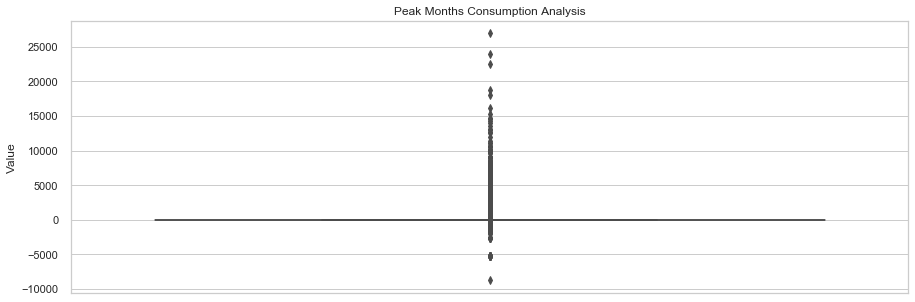

In [7]:
base = yellow_trips_2.copy()

# Heat map of energy consumption by month and year
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.boxplot( y="amount_per_distance", data=base, ax = ax)
ax.set_title('Peak Months Consumption Analysis');
ax.set(ylabel='Value')

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [8]:
def drop_outliers_iqr(base, var):

    q1 = base[var].quantile(0.25)
    q3 = base[var].quantile(0.75)

    iqr = q3 - q1

    min_val = q1-1.5*iqr
    max_val = q3+1.5*iqr

    print(max_val)

    base['Eliminate'] = np.where(np.logical_or(base[var] > max_val, 
                                                  (base[var] < min_val)), 1, 0)

    base = base.loc[base['Eliminate'] == 0]
    base = base.drop('Eliminate', axis = 1)
    return base

In [9]:
print('Cleaning Total Amout Outliers')
print('Shape before:', yellow_trips_2.shape)
yellow_trips_2 = drop_outliers_iqr(yellow_trips_2, 'amount_per_distance')
print('Shape after:', yellow_trips_2.shape)

Cleaning Total Amout Outliers
Shape before: (7926168, 12)
13.573011573504063


C:\Users\johns\Anaconda3\envs\DS4A_test\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shape after: (7588170, 12)


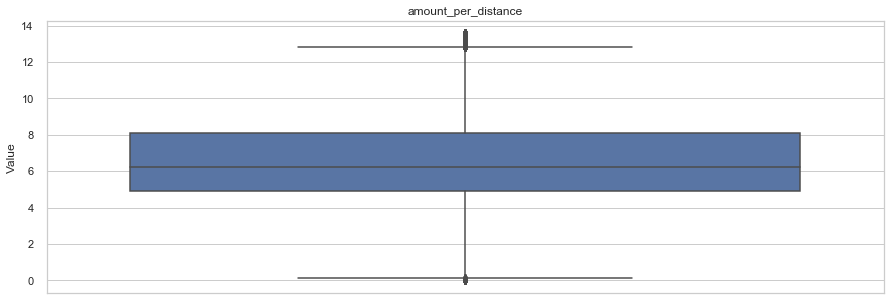

In [10]:
base = yellow_trips_2.copy()
# Heat map of energy consumption by month and year
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.boxplot(y="amount_per_distance", data=base, ax = ax)
ax.set_title('amount_per_distance');
ax.set(ylabel='Value')

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [11]:
path = 'DataSet/Parquets'
yellow_trips_2.to_parquet(path + '/yellow_trips_filtered.parquet', engine = 'pyarrow')